<a href="https://colab.research.google.com/github/jeremiecoullon/vae_example/blob/main/VAE_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install flax  
`!pip install -q flax`

In [1]:
import jax.numpy as jnp
import jax
from jax import random, jit, vmap, lax, grad, value_and_grad
from jax.tree_util import tree_map

from flax import linen as nn
from flax.training import train_state

import numpy as np
import optax
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from functools import partial
import tqdm
from typing import Sequence

import os

## Load data

In [ ]:
def get_datasets(dataset_name, download_dir=os.getcwd()):
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder(dataset_name)
  ds_builder.download_and_prepare(download_dir=download_dir) #<- add a function to specify the dir
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds


train_ds, test_ds = get_datasets("fashion_mnist")
my_train_labels = jax.nn.one_hot(train_ds['label'], num_classes=10)
my_train_images = train_ds['image']

@partial(jit, static_argnums=(3,))
def get_batch(key, my_train_images, my_train_labels, batch_size):
  idx_batch = random.choice(key, jnp.arange(len(my_train_images)), shape=(batch_size,), replace=True)

  batch_images = my_train_images[idx_batch]
  batch_labels = my_train_labels[idx_batch]
  return batch_images, batch_labels


<function matplotlib.pyplot.show(close=None, block=None)>

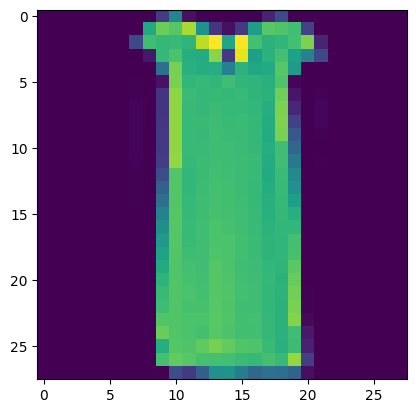

In [3]:
batch_size = 32
key = random.PRNGKey(0)

batch_images, batch_labels = get_batch(key, my_train_images, my_train_labels, batch_size)

batch_images.shape, batch_labels.shape

plt.imshow(batch_images[0].squeeze())
plt.show

# Variational Autoencoder

In [4]:

class Encoder(nn.Module):
  "Last feature size is the size of the latent space"
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    mean_x = nn.Dense(self.features[-1], name="le_mean")(x)
    logstd_x = nn.Dense(self.features[-1], name="le_logstd")(x)
    return mean_x, logstd_x

class Decoder(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    return nn.Dense(self.features[-1])(x)


# helper function
def sample_gaussian(key, mean, logstd):
    "Sample a Gaussian with mean and diagonal covariance matrix"
    return jnp.exp(logstd)*random.normal(key, shape=mean.shape) + mean #<- add jnp.exp


class VAE(nn.Module):
  encoder_widths: Sequence[int]
  decoder_widths: Sequence[int]
  input_shape: Sequence[int]

  def setup(self):
    input_dim = np.prod(self.input_shape)
    self.encoder = Encoder(self.encoder_widths)
    self.decoder = Decoder(self.decoder_widths + (input_dim,))

  def __call__(self, x, z_rng):
    mean, logstd = self.encoder(x)
    z = sample_gaussian(z_rng, mean, logstd)
    x_reconstructed = self.decoder(z)#.reshape((mean.shape[0],) + self.input_shape)
    return x_reconstructed, mean, logstd

  def decode(self, z):
    return nn.sigmoid(self.decoder(z))

  def encode(self, x):
    assert x.shape[1:] == self.input_shape
    return self.encoder(jnp.reshape(x, (x.shape[0], -1)))

  def generate(self, key, params):
    dim_latent = self.encoder_widths[-1]
    z = random.normal(key, shape=(1, dim_latent))
    return self.apply(params, z, method=self.decode).reshape((28, 28))

  def interpolate(self, params, image_1, image_2, alpha):
    z1, _ = self.apply(params, image_1[jnp.newaxis,:,:,:], method=self.encode)
    z2, _ = self.apply(params, image_2[jnp.newaxis,:,:,:], method=self.encode)
    z_interp = z1*(1-alpha) + alpha*z2 
    return self.apply(params, z_interp, method=self.decode).reshape((28, 28))



In [5]:
# =====
# ELBO optimiser

@vmap
def log_lik(x, x_reconstructed):
  var = 1
  x = x.flatten()
  diff = x-x_reconstructed
  return -(1/var)*jnp.dot(diff, diff)

@vmap
def kl_divergence(mean, logstd):
  return -0.5*jnp.sum(1 + 2*logstd - jnp.square(jnp.exp(logstd)) - jnp.square(mean))

def neg_elbo(key, params, batch_images):
  x_reconstructed, mean, logstd = model_vae.apply(params, batch_images, key)
  return - log_lik(batch_images, x_reconstructed).mean() + kl_divergence(mean, logstd).mean()

@jit
def step(key, params, opt_state):
  "Run 1 step of ELBO optimiser"
  subkey1, subkey2 = random.split(key)
  batch_images, _ = get_batch(subkey1, my_train_images, my_train_labels, 32)
  loss, grads = value_and_grad(neg_elbo, 1)(subkey2, params, batch_images)
  
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss



### Optimise ELBO

Current loss: 28.83307: 100%|██████████| 5000/5000 [00:18<00:00, 269.10it/s]


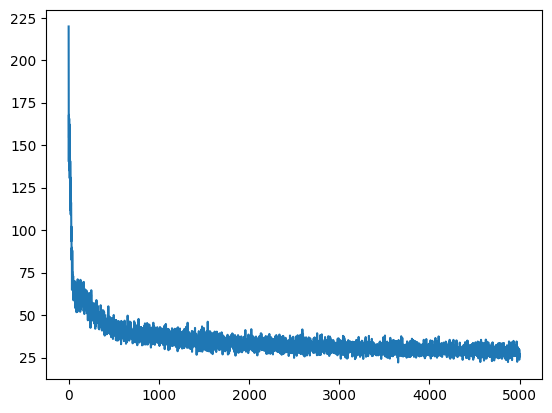

In [ ]:
loss_list = []

optimizer = optax.adam(1e-3) #<- fine-tune the lr a little bit

dim_latent = 20
model_vae = VAE(encoder_widths=[100, 784, dim_latent], 
                decoder_widths=[dim_latent, 784, 100], 
                input_shape=batch_images.shape[1:])

key = random.PRNGKey(0)
key, subkey1, subkey2 = random.split(key, 3)
params = model_vae.init(subkey1, batch_images, subkey2)
opt_state = optimizer.init(params)

Niters = 5_000

pbar = tqdm.tqdm(range(Niters))
for i in pbar:
  key, subkey = random.split(key)
  params, opt_state, loss = step(key, params, opt_state)
  loss_list.append(loss)
  if i%100==0:
    pbar.set_description(f"Current loss: {loss:.5f}")

plt.plot(loss_list)

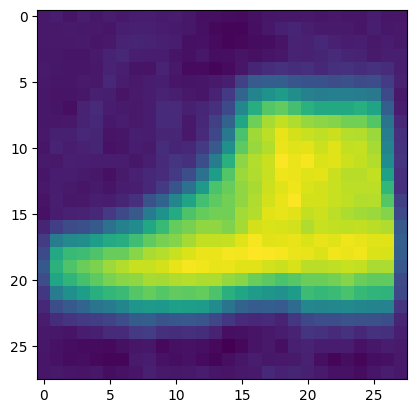

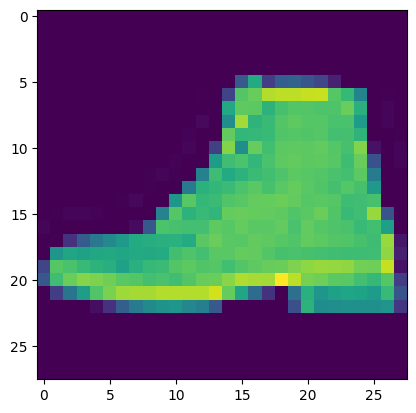

In [7]:
# Look at sampled reconstructed images

key = random.PRNGKey(790)
x_rec, mean, logstd = model_vae.apply(params, batch_images, key)

idx = 29

plt.imshow(x_rec.reshape((32, 28, 28,1))[idx, :,:,0])
plt.show()
plt.imshow(batch_images[idx, :,:,0])
plt.show()

# Sample new images from latent space


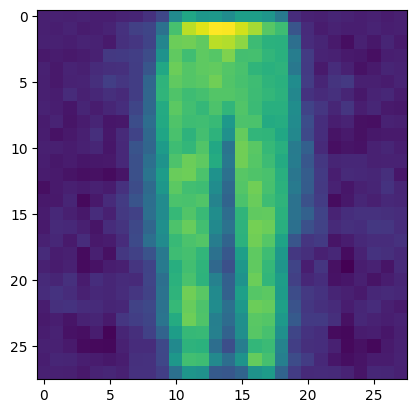

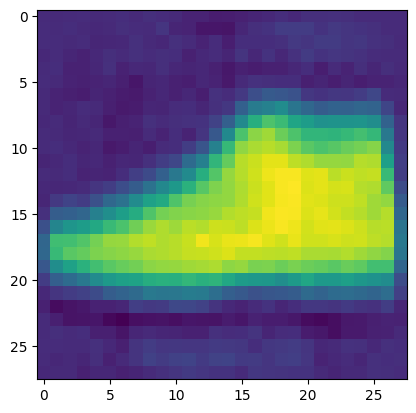

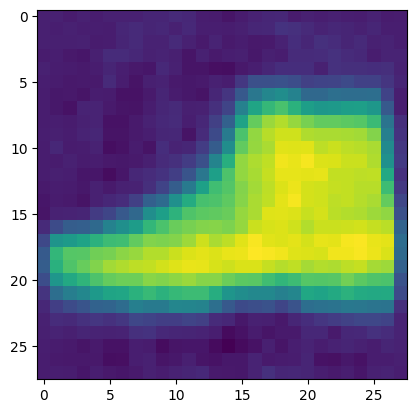

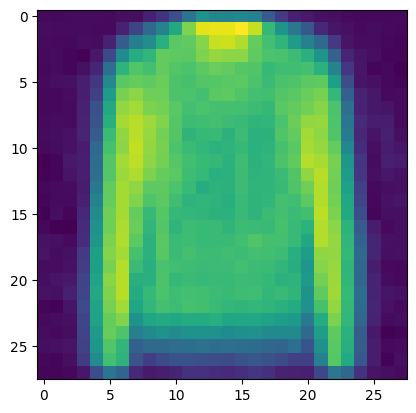

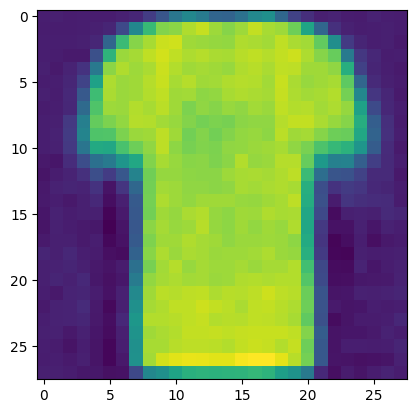

In [8]:
key = random.PRNGKey(790)

for _ in range(5):
  key, subkey = random.split(key)
  plt.imshow(model_vae.generate(subkey, params))
  plt.show()

# Interpolate between images

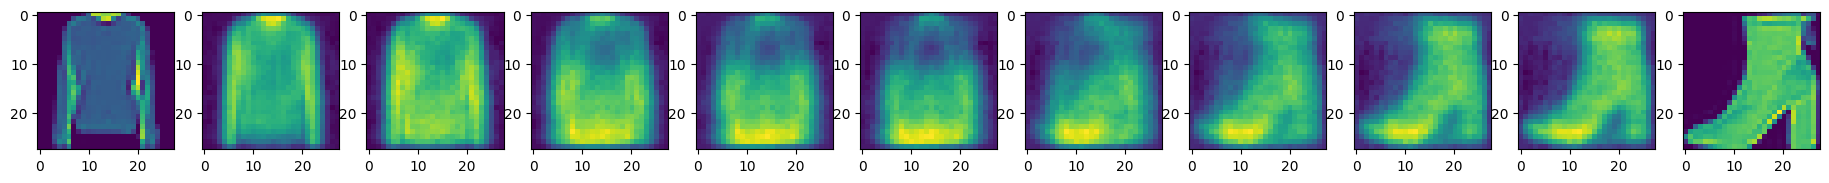

In [9]:
img_1 = my_train_images[0]
img_2 = my_train_images[11]

list_alpha = np.arange(0.1, 1, 0.1)

fig, ax = plt.subplots(1, len(list_alpha)+2, figsize=(23, 5))
ax[0].imshow(img_1.squeeze())

for idx, alpha in enumerate(list_alpha):
  img_interp = model_vae.interpolate(params, img_1, img_2, alpha)
  ax[idx+1].imshow(img_interp) 

ax[-1].imshow(img_2.squeeze())
plt.show()